In [462]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [463]:
import warnings 
warnings.filterwarnings('ignore')

<h5> Load dataset </h5>

In [464]:
df_daily = pd.read_csv('cleaned_data/df_daily.csv')


<h5> Make initial selection of features to create X and y </h5>

In [465]:
X = df_daily.drop('Unnamed: 0', axis = 1)
X = X.drop(['casual', 'registered', 'total', 'dew_point', 'year_month','app_temp_cat', 'date', 'calendar_week'], axis = 1)
y = df_daily['total']

In [466]:
X.head(3)

,season,year,month,holiday,day_of_week,work_day,weather_sit,temp,app_temp,humidity,wind_speed
0,winter,2011,1,no,sat,no,misty,8.2,8.0,80.6,10.7
1,winter,2011,1,no,sun,no,misty,9.1,7.3,69.6,16.7
2,winter,2011,1,no,mon,yes,clear,1.2,-3.5,43.7,16.6


In [467]:
# change datatype for "month" and "year" to string (in order to one-hot encode)
X['month'] = X['month'].apply(str)
X['year'] = X['year'].apply(str)

- Numerical variables: temp, app_temp, humidity, wind_speed
- Categorical variables: season, year, month, holiday, day_of_week, work_day, weather_sit

<h5> One-hot encoding for categorical variables </h5>

In [468]:
# one-hot encode the categorical variables
X_enc = pd.get_dummies(X, drop_first = True)

<h3> Remove variables with multicollinearity </h3>

<h5> Function for computing VIF </h5>

In [469]:
def compute_vif(considered_features):
    X_temp = X_enc.copy(deep = True)

    # scale continuous variables
    scaler = StandardScaler()
    scaler.fit(X_temp[['temp', 'app_temp', 'humidity']])
    X_temp[['temp', 'app_temp', 'humidity']] = scaler.transform(X_temp[['temp', 'app_temp', 'humidity']])

    # Select considered features only
    X_temp = X_enc[considered_features]

    # Add intercept = 1 for ViF calculation:
    X_temp['intercept'] = 1

    # Create dataframe to store values
    vif = pd.DataFrame()
    vif['variable'] = X_temp.columns
    vif['vif'] = [variance_inflation_factor(X_temp.values, i) for i in list(range(X_temp.shape[1]))]
    vif = vif[vif['variable']!= 'intercept']
    return vif


<h5> Now iteratively remove variables with VIF over 5 </h5>

In [470]:
# Compute VIF for full list of features
considered_features = X_enc.columns.tolist()
compute_vif(considered_features)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,season_spring,inf
5,season_summer,inf
6,season_winter,inf
7,year_2012,1.046125
8,month_10,inf
9,month_11,inf


In [471]:
# We know that "work_day" depends on "day_of_week" and "holiday", so remove "work_day":
considered_features.remove('work_day_yes')
considered_features2 = considered_features
compute_vif(considered_features2)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,season_spring,inf
5,season_summer,inf
6,season_winter,inf
7,year_2012,1.046125
8,month_10,inf
9,month_11,inf


In [472]:
# Good. Now all the "day_of_week" values are reasonable.
# Now I'm not sure whether to remove the seasons or the months. 
# Seasonal boundaries fall in the middle of different months, so removing seasons leads to loss of info.
# But the weather conditions do fluctuate from month to month within same season.
# For now, remove the seasons.

considered_features2.remove('season_winter')
considered_features3 = considered_features2
compute_vif(considered_features3)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,season_spring,inf
5,season_summer,inf
6,year_2012,1.046125
7,month_10,2.779288
8,month_11,2.075357
9,month_12,1.971167


In [473]:
# Remove summer

considered_features3.remove('season_summer')
considered_features4 = considered_features3
compute_vif(considered_features4)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,season_spring,inf
5,year_2012,1.046125
6,month_10,2.779288
7,month_11,2.075357
8,month_12,1.971167
9,month_2,1.834470


In [474]:
# Remove spring
considered_features4.remove('season_spring')
considered_features5 = considered_features4
compute_vif(considered_features5)

,variable,vif
0,temp,80.349018
1,app_temp,69.969222
2,humidity,2.132518
3,wind_speed,1.261929
4,year_2012,1.046125
5,month_10,2.779288
6,month_11,2.075357
7,month_12,1.971167
8,month_2,1.834470
9,month_3,2.219708


In [475]:
# Remove app_temp
considered_features5.remove('temp')
considered_features6 = considered_features5
compute_vif(considered_features6)

,variable,vif
0,app_temp,5.951702
1,humidity,2.130698
2,wind_speed,1.206828
3,year_2012,1.041506
4,month_10,2.725352
5,month_11,2.070150
6,month_12,1.970113
7,month_2,1.833683
8,month_3,2.198147
9,month_4,2.618455


In [476]:
# Our three weather_sit classes were: "clear", "misty", and "bit wet"
# If we drop "misty", then we'd be lumping "misty" together with "bit wet", which doesn't seem right. 
# Keep both "weather_sit" values for now, even though the VIFs are high-ish. 
# Also keep "app_temp" in spite of the high VIF, since we know from the EDA it will be an important predictor.

In [477]:
# Save our chosen features
selected_features = considered_features6

<h3> Now select variables that meaningfully predict outcome </h3>

<h5> Compute p-value for variables + iteratively remove variable with p-value above 0.05 </h5>

In [478]:
# Copy X dataframe and scale numerical variables

X_opt = X_enc.copy(deep = True)
X_opt = X_opt[selected_features]

scaler = StandardScaler()
scaler.fit(X_opt[['wind_speed', 'app_temp', 'humidity']])
X_opt[['wind_speed', 'app_temp', 'humidity']] = scaler.transform(X_opt[['wind_speed', 'app_temp', 'humidity']])
X_opt.head(3)

,app_temp,humidity,wind_speed,year_2012,month_10,month_11,month_12,month_2,month_3,month_4,...,month_9,holiday_yes,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,weather_sit_clear,weather_sit_misty
0,-0.679543,1.251378,-0.397734,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,-0.744659,0.478565,0.758610,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,-1.749314,-1.341058,0.739338,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [479]:
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1063.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:25:45   Log-Likelihood:                         -5928.4
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     707   BIC:                                  1.202e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            690.0325     64.252     10.740      0.000     563.886     816.179
humidity           -173.4975     41.819     -4.149      0.000    -255.601     -91.394
wind_speed         -218.9681     32.875     -6.661      0.000    -283.513    -154.423
year_2012          2050.3401     61.075     33.571      0.000    1930.431    2170.250
month_10           2330.5034    153.074     15.225      0.000    2029.970    2631.037
month_11           1627.6370    142.761     11.401      0.000    1347.351    1907.923
month_12           1058.8199    140.496      7.536      0.000     782.980    1334.660
month_2             270.5037    143.130      1.890      0.059     -10.507     551.514
month_3            1053.4907    143.564      7.338      0.000     771.629    1335.353
month_4            1579.3845    154.639     10.213      0.000    1275.777    1882.992
month_5            1907.5014    177.554     10.743      0.000    1558.905    2256.097
month_6            1774.9903    195.154      9.095      0.000    1391.839    2158.141
month_7            1299.0223    210.762      6.163      0.000     885.229    1712.816
month_8            1689.7559    197.659      8.549      0.000    1301.688    2077.824
month_9            2364.6203    177.973     13.286      0.000    2015.202    2714.039
holiday_yes        -684.1944    190.612     -3.589      0.000   -1058.428    -309.961
day_of_week_mon    -148.6622    113.260     -1.313      0.190    -371.028      73.703
day_of_week_sat      61.4029    110.502      0.556      0.579    -155.549     278.355
day_of_week_sun    -386.9456    111.819     -3.460      0.001    -606.483    -167.408
day_of_week_thu      33.3150    109.748      0.304      0.762    -182.156     248.786
day_of_week_tue     -43.2940    110.129     -0.393      0.694    -259.514     172.926
day_of_week_wed      34.0729    109.822      0.310      0.756    -181.543     249.689
weather_sit_clear  2373.7769    133.382     17.797      0.000    2111.904    2635.650
weather_sit_misty  1875.1864    131.149     14.298      0.000    1617.699    2132.674
==============================================================================
Omnibus:                      115.836   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.256
Skew:                          -0.815   Prob(JB):                     8.54e-67
Kurtosis:                       5.708   Cond. No.                         18.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly spec

In [480]:
# Highest p-value comes from day_of_week_mon, so drop that.
selected_features.remove('day_of_week_mon')
selected_features2 = selected_features
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features2]).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1108.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:25:45   Log-Likelihood:                         -5929.3
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     708   BIC:                                  1.201e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            700.1481     63.820     10.971      0.000     574.848     825.448
humidity           -181.5649     41.386     -4.387      0.000    -262.818    -100.311
wind_speed         -221.6922     32.827     -6.753      0.000    -286.141    -157.243
year_2012          2046.6496     61.041     33.529      0.000    1926.806    2166.493
month_10           2305.3110    151.943     15.172      0.000    2006.997    2603.625
month_11           1613.8883    142.449     11.330      0.000    1334.216    1893.560
month_12           1044.7523    140.158      7.454      0.000     769.576    1319.928
month_2             256.6330    142.812      1.797      0.073     -23.753     537.019
month_3            1034.0839    142.873      7.238      0.000     753.578    1314.590
month_4            1556.3449    153.718     10.125      0.000    1254.546    1858.143
month_5            1881.6219    176.546     10.658      0.000    1535.006    2228.238
month_6            1740.6677    193.493      8.996      0.000    1360.779    2120.557
month_7            1261.5072    208.921      6.038      0.000     851.328    1671.687
month_8            1655.6680    196.045      8.445      0.000    1270.769    2040.567
month_9            2338.8291    176.975     13.216      0.000    1991.371    2686.288
holiday_yes        -737.2390    186.374     -3.956      0.000   -1103.151    -371.327
day_of_week_sat     127.9124     98.250      1.302      0.193     -64.984     320.809
day_of_week_sun    -318.7377     99.062     -3.218      0.001    -513.228    -124.248
day_of_week_thu      99.3835     97.574      1.019      0.309     -92.185     290.953
day_of_week_tue      23.1793     97.844      0.237      0.813    -168.920     215.279
day_of_week_wed     100.0223     97.704      1.024      0.306     -91.802     291.847
weather_sit_clear  2326.6965    128.535     18.102      0.000    2074.342    2579.051
weather_sit_misty  1838.2685    128.162     14.343      0.000    1586.645    2089.892
==============================================================================
Omnibus:                      114.366   Durbin-Watson:                   1.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              301.662
Skew:                          -0.804   Prob(JB):                     3.13e-66
Kurtosis:                       5.705   Cond. No.                         18.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [481]:
# Highest p-value from day_of_week_tue
selected_features2.remove('day_of_week_tue')
selected_features3 = selected_features2
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features3]).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1160.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:25:45   Log-Likelihood:                         -5929.3
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     709   BIC:                                  1.200e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            699.3117     63.680     10.982      0.000     574.287     824.336
humidity           -180.7070     41.200     -4.386      0.000    -261.595     -99.819
wind_speed         -221.3117     32.765     -6.754      0.000    -285.641    -156.983
year_2012          2047.0921     60.972     33.574      0.000    1927.385    2166.799
month_10           2308.0677    151.396     15.245      0.000    2010.829    2605.306
month_11           1616.4836    141.932     11.389      0.000    1337.826    1895.141
month_12           1046.5272    139.865      7.482      0.000     771.928    1321.126
month_2             258.6701    142.458      1.816      0.070     -21.020     538.360
month_3            1036.4420    142.431      7.277      0.000     756.805    1316.079
month_4            1558.8187    153.261     10.171      0.000    1257.919    1859.719
month_5            1884.7916    175.921     10.714      0.000    1539.403    2230.180
month_6            1744.0328    192.842      9.044      0.000    1365.422    2122.643
month_7            1265.5114    208.098      6.081      0.000     856.950    1674.073
month_8            1658.9872    195.414      8.490      0.000    1275.329    2042.646
month_9            2341.7647    176.423     13.274      0.000    1995.391    2688.139
holiday_yes        -742.7691    184.783     -4.020      0.000   -1105.557    -379.981
day_of_week_sat     120.2866     92.766      1.297      0.195     -61.841     302.415
day_of_week_sun    -326.5454     93.356     -3.498      0.000    -509.833    -143.258
day_of_week_thu      91.9784     92.370      0.996      0.320     -89.373     273.330
day_of_week_wed      92.5462     92.406      1.002      0.317     -88.876     273.968
weather_sit_clear  2332.0209    126.470     18.439      0.000    2083.720    2580.322
weather_sit_misty  1842.6422    126.741     14.539      0.000    1593.809    2091.475
==============================================================================
Omnibus:                      114.318   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              301.010
Skew:                          -0.804   Prob(JB):                     4.33e-66
Kurtosis:                       5.701   Cond. No.                         18.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [482]:
# Highest p-value from day_of_week_thu
selected_features3.remove('day_of_week_thu')
selected_features4 = selected_features3
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features4]).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1215.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:25:45   Log-Likelihood:                         -5929.8
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     710   BIC:                                  1.200e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            697.8012     63.662     10.961      0.000     572.813     822.789
humidity           -181.4231     41.193     -4.404      0.000    -262.298    -100.548
wind_speed         -220.8390     32.762     -6.741      0.000    -285.161    -156.517
year_2012          2047.6738     60.969     33.586      0.000    1927.973    2167.374
month_10           2317.4172    151.104     15.337      0.000    2020.753    2614.081
month_11           1625.7769    141.624     11.480      0.000    1347.725    1903.829
month_12           1055.4430    139.577      7.562      0.000     781.410    1329.476
month_2             265.6714    142.284      1.867      0.062     -13.675     545.018
month_3            1045.5927    142.133      7.356      0.000     766.541    1324.645
month_4            1566.7583    153.053     10.237      0.000    1266.268    1867.248
month_5            1894.8858    175.628     10.789      0.000    1550.074    2239.697
month_6            1754.3475    192.563      9.111      0.000    1376.287    2132.408
month_7            1275.3776    207.861      6.136      0.000     867.283    1683.472
month_8            1669.1271    195.147      8.553      0.000    1285.993    2052.261
month_9            2353.7292    176.012     13.373      0.000    2008.162    2699.296
holiday_yes        -755.7808    184.320     -4.100      0.000   -1117.657    -393.904
day_of_week_sat      97.5831     89.919      1.085      0.278     -78.957     274.123
day_of_week_sun    -349.5143     90.461     -3.864      0.000    -527.118    -171.911
day_of_week_wed      70.6724     89.756      0.787      0.431    -105.547     246.892
weather_sit_clear  2346.5314    125.627     18.679      0.000    2099.886    2593.176
weather_sit_misty  1855.9486    126.034     14.726      0.000    1608.505    2103.393
==============================================================================
Omnibus:                      114.966   Durbin-Watson:                   1.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.270
Skew:                          -0.807   Prob(JB):                     8.49e-67
Kurtosis:                       5.718   Cond. No.                         17.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [483]:
# Highest p-value from day_of_week_sat
selected_features4.remove('day_of_week_sat')
selected_features5 = selected_features4
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features5]).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1275.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:25:45   Log-Likelihood:                         -5930.4
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     711   BIC:                                  1.199e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            690.3736     63.301     10.906      0.000     566.095     814.652
humidity           -179.9038     41.174     -4.369      0.000    -260.742     -99.066
wind_speed         -219.6788     32.748     -6.708      0.000    -283.974    -155.384
year_2012          2048.8028     60.967     33.605      0.000    1929.105    2168.501
month_10           2330.5267    150.639     15.471      0.000    2034.776    2626.277
month_11           1633.2345    141.475     11.544      0.000    1355.476    1910.993
month_12           1063.2759    139.408      7.627      0.000     789.576    1336.976
month_2             270.5893    142.229      1.902      0.058      -8.650     549.829
month_3            1053.5899    141.960      7.422      0.000     774.879    1332.301
month_4            1579.1882    152.643     10.346      0.000    1279.504    1878.872
month_5            1909.9377    175.101     10.908      0.000    1566.161    2253.714
month_6            1774.5417    191.686      9.258      0.000    1398.204    2150.879
month_7            1298.8075    206.762      6.282      0.000     892.870    1704.745
month_8            1687.8005    194.411      8.682      0.000    1306.112    2069.489
month_9            2371.7431    175.250     13.533      0.000    2027.674    2715.812
holiday_yes        -774.6902    183.517     -4.221      0.000   -1134.990    -414.390
day_of_week_sun    -370.3162     88.418     -4.188      0.000    -543.908    -196.725
day_of_week_wed      51.1845     87.953      0.582      0.561    -121.493     223.863
weather_sit_clear  2355.0849    125.395     18.781      0.000    2108.896    2601.274
weather_sit_misty  1860.7890    125.971     14.772      0.000    1613.470    2108.108
==============================================================================
Omnibus:                      111.714   Durbin-Watson:                   1.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.730
Skew:                          -0.782   Prob(JB):                     1.35e-65
Kurtosis:                       5.714   Cond. No.                         17.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [484]:
# Highest p-value from day_of_week_wed
selected_features5.remove('day_of_week_wed')
selected_features6 = selected_features5
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features6]).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1344.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:25:45   Log-Likelihood:                         -5930.6
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     712   BIC:                                  1.199e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            688.5019     63.190     10.896      0.000     564.442     812.562
humidity           -177.8493     41.004     -4.337      0.000    -258.352     -97.347
wind_speed         -219.5772     32.733     -6.708      0.000    -283.841    -155.313
year_2012          2049.8411     60.913     33.652      0.000    1930.250    2169.432
month_10           2335.5047    150.326     15.536      0.000    2040.369    2630.640
month_11           1637.7763    141.194     11.599      0.000    1360.570    1914.982
month_12           1066.1167    139.258      7.656      0.000     792.712    1339.521
month_2             275.5291    141.910      1.942      0.053      -3.082     554.141
month_3            1058.4320    141.650      7.472      0.000     780.330    1336.534
month_4            1584.5488    152.294     10.405      0.000    1285.550    1883.547
month_5            1915.7368    174.736     10.964      0.000    1572.677    2258.796
month_6            1782.2837    191.135      9.325      0.000    1407.029    2157.539
month_7            1306.2231    206.273      6.332      0.000     901.247    1711.200
month_8            1695.5636    193.863      8.746      0.000    1314.952    2076.175
month_9            2376.9802    174.937     13.588      0.000    2033.526    2720.435
holiday_yes        -780.3848    183.171     -4.260      0.000   -1140.004    -420.765
day_of_week_sun    -379.0284     87.101     -4.352      0.000    -550.034    -208.023
weather_sit_clear  2358.9734    125.159     18.848      0.000    2113.249    2604.698
weather_sit_misty  1861.8216    125.900     14.788      0.000    1614.642    2109.001
==============================================================================
Omnibus:                      113.353   Durbin-Watson:                   1.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.028
Skew:                          -0.791   Prob(JB):                     5.81e-67
Kurtosis:                       5.741   Cond. No.                         17.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [485]:
# Highest p-value from month_2
selected_features6.remove('month_2')
selected_features7 = selected_features6
regressor_OLS = sm.OLS(endog = y, exog = X_opt[selected_features7]).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1413.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:25:45   Log-Likelihood:                         -5932.5
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     713   BIC:                                  1.198e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            687.1643     63.308     10.854      0.000     562.871     811.457
humidity           -170.9957     40.931     -4.178      0.000    -251.355     -90.636
wind_speed         -213.5722     32.650     -6.541      0.000    -277.673    -149.471
year_2012          2054.7174     60.979     33.695      0.000    1934.997    2174.438
month_10           2227.3515    139.896     15.922      0.000    1952.695    2502.008
month_11           1526.4269    129.272     11.808      0.000    1272.627    1780.227
month_12            954.5288    127.091      7.511      0.000     705.012    1204.046
month_3             944.8665    129.260      7.310      0.000     691.090    1198.643
month_4            1470.6803    140.821     10.444      0.000    1194.207    1747.154
month_5            1798.4933    164.288     10.947      0.000    1475.946    2121.040
month_6            1668.9579    182.358      9.152      0.000    1310.936    2026.980
month_7            1195.2743    198.585      6.019      0.000     805.394    1585.155
month_8            1581.0729    185.035      8.545      0.000    1217.794    1944.352
month_9            2265.8066    165.622     13.681      0.000    1940.642    2590.971
holiday_yes        -786.0787    183.503     -4.284      0.000   -1146.349    -425.808
day_of_week_sun    -380.9020     87.265     -4.365      0.000    -552.228    -209.576
weather_sit_clear  2476.7401    109.692     22.579      0.000    2261.383    2692.098
weather_sit_misty  1969.3834    113.276     17.386      0.000    1746.990    2191.777
==============================================================================
Omnibus:                      112.299   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.755
Skew:                          -0.785   Prob(JB):                     4.92e-66
Kurtosis:                       5.722   Cond. No.                         15.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [486]:
# Good. Now we have our final list. 
final_selected_features = selected_features7
final_selected_features


['app_temp',
 'humidity',
 'wind_speed',
 'year_2012',
 'month_10',
 'month_11',
 'month_12',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'holiday_yes',
 'day_of_week_sun',
 'weather_sit_clear',
 'weather_sit_misty']

- I feel uncomfortable having dropped day_of_week_sat. Maybe go back and put it back in. 

In [487]:
final_selected_features = final_selected_features + ['day_of_week_sat']
final_selected_features

['app_temp',
 'humidity',
 'wind_speed',
 'year_2012',
 'month_10',
 'month_11',
 'month_12',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'holiday_yes',
 'day_of_week_sun',
 'weather_sit_clear',
 'weather_sit_misty',
 'day_of_week_sat']

In [488]:
regressor_OLS = sm.OLS(endog = y, exog = X_opt[final_selected_features]).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1338.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:25:46   Log-Likelihood:                         -5932.0
No. Observations:                 731   AIC:                                  1.190e+04
Df Residuals:                     712   BIC:                                  1.199e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
app_temp            693.1428     63.602     10.898      0.000     568.274     818.012
humidity           -171.7176     40.938     -4.195      0.000    -252.092     -91.343
wind_speed         -214.6273     32.668     -6.570      0.000    -278.764    -150.490
year_2012          2054.0179     60.985     33.681      0.000    1934.286    2173.750
month_10           2218.4482    140.192     15.824      0.000    1943.209    2493.688
month_11           1522.4284    129.340     11.771      0.000    1268.496    1776.361
month_12            949.6239    127.192      7.466      0.000     699.908    1199.340
month_3             940.5120    129.339      7.272      0.000     686.580    1194.444
month_4            1462.5661    141.066     10.368      0.000    1185.610    1739.522
month_5            1788.2313    164.624     10.863      0.000    1465.025    2111.438
month_6            1654.7466    182.935      9.046      0.000    1295.590    2013.903
month_7            1178.0548    199.361      5.909      0.000     786.649    1569.461
month_8            1568.2312    185.501      8.454      0.000    1204.037    1932.425
month_9            2252.6639    166.165     13.557      0.000    1926.432    2578.896
holiday_yes        -771.1508    184.135     -4.188      0.000   -1132.663    -409.638
day_of_week_sun    -365.3508     88.690     -4.119      0.000    -539.477    -191.225
weather_sit_clear  2469.3036    109.955     22.457      0.000    2253.428    2685.179
weather_sit_misty  1964.3794    113.393     17.324      0.000    1741.755    2187.004
day_of_week_sat      86.6888     88.228      0.983      0.326     -86.530     259.907
==============================================================================
Omnibus:                      115.830   Durbin-Watson:                   1.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.183
Skew:                          -0.811   Prob(JB):                     1.20e-67
Kurtosis:                       5.737   Cond. No.                         15.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h3> Build base model (no regularisation) </h3>

<h4> Base model </h4>

In [508]:
X_final = X_enc[final_selected_features]
y = y

# split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=101)

# scale data
scaler = StandardScaler()
scaler.fit(X_train[['app_temp', 'humidity']])
X_train[['app_temp', 'humidity']] = scaler.transform(X_train[['app_temp', 'humidity']])
X_test[['app_temp', 'humidity']] = scaler.transform(X_test[['app_temp', 'humidity']])

# build model
basic_model = Ridge()
basic_model.fit(X_train, y_train)
y_pred_train = basic_model.predict(X_train)
y_pred_test = basic_model.predict(X_test)

MSE_train = mean_squared_error(y_pred_train, y_train)
MSE_test = mean_squared_error(y_pred_test, y_test)


RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

# Print accuracy
100 * (1 - (RMSE_test / (df_daily['total'].mean()))), r2_score(y_pred_train, y_train)

(82.32510714062414, 0.7787086519809934)

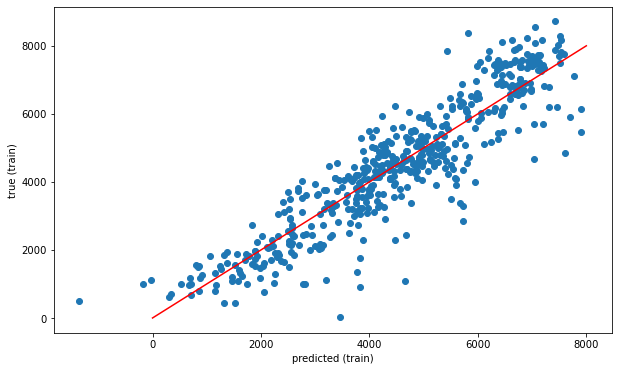

In [490]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(y_pred_train, y_train)
ax.set_xlabel('predicted (train)')
ax.set_ylabel('true (train)')
ax.plot(list(range(8000)), list(range(8000)), color = 'r')
plt.show()

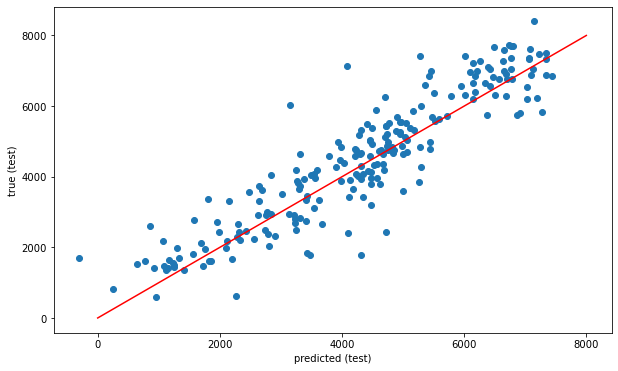

In [491]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(y_pred_test, y_test)
ax.set_xlabel('predicted (test)')
ax.set_ylabel('true (test)')
ax.plot(list(range(8000)), list(range(8000)), color = 'r')
plt.show()

- Good. True values seem randomly distributed to the left and right of the predicted values.

In [492]:
# Coefficients
dict(zip(basic_model.feature_names_in_, basic_model.coef_)), basic_model.intercept_

({'app_temp': 1025.9643932535344,
  'humidity': -291.82591145930036,
  'wind_speed': -50.715078986502164,
  'year_2012': 1970.1728469752159,
  'month_10': 1620.8126911362333,
  'month_11': 969.6678099359794,
  'month_12': 594.3115186985368,
  'month_3': 564.8153090020917,
  'month_4': 897.9771228549973,
  'month_5': 1125.9280415431854,
  'month_6': 612.4761464552159,
  'month_7': 74.17880128472298,
  'month_8': 588.7855640521685,
  'month_9': 1560.0958835177448,
  'holiday_yes': -1054.6339626570561,
  'day_of_week_sun': -320.8999275520096,
  'weather_sit_clear': 1801.560285144292,
  'weather_sit_misty': 1386.5010142940018,
  'day_of_week_sat': 120.76943442471078},
 1846.820800563703)

- humidity is negative predictor
- app_temp is positive predictor (because temp goes from around -10 to 35, so within this range, riders will prefer warmer temps)
- winter months are positive predictors, summer months are negative predictors. This seems faulty. 
- holiday day is negative predictor. This makes sense, since majority of riders are registered, who tend to ride to commute. 
- sunday is negative predictor, which makes sense for reason above
- saturday is positive predictor, which is mysterious, for reason above
- clear and misty weather are positive predictors – makes sense, since alternative is 'bit wet'

<h3> Alternative feature selection process </h3>

- Instead of eliminating features based on VIF value and p-value, use common sense and domain knowledge
- We saw during the EDA that work_day was a strong predictor. So keep that, rather than the individual day_of_week
- Also, use seasons instead of months (this reduces number of features, while preserving the relevant information)
- Keep weather situations for now

In [493]:
X_enc.head(2)

,temp,app_temp,humidity,wind_speed,season_spring,season_summer,season_winter,year_2012,month_10,month_11,...,holiday_yes,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,work_day_yes,weather_sit_clear,weather_sit_misty
0,8.2,8.0,80.6,10.7,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,9.1,7.3,69.6,16.7,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [494]:
features_list = ['year_2012', 'wind_speed', 'temp', 'humidity', 'season_spring', 'season_summer', 'season_winter', 'work_day_yes', 'weather_sit_clear', 'weather_sit_misty']
compute_vif(features_list)

,variable,vif
0,year_2012,1.036951
1,wind_speed,1.187543
2,temp,3.725095
3,humidity,2.039152
4,season_spring,1.588960
5,season_summer,2.750614
6,season_winter,2.279508
7,work_day_yes,1.009997
8,weather_sit_clear,10.821868
9,weather_sit_misty,9.155738


In [495]:
X_opt = X_enc.copy(deep = True)
X_opt = X_opt[features_list]

scaler = StandardScaler()
scaler.fit(X_opt[['wind_speed', 'temp', 'humidity']])
X_opt[['wind_speed', 'temp', 'humidity']] = scaler.transform(X_opt[['wind_speed', 'temp', 'humidity']])
X_opt.head(3)

,year_2012,wind_speed,temp,humidity,season_spring,season_summer,season_winter,work_day_yes,weather_sit_clear,weather_sit_misty
0,0,-0.397734,-0.823931,1.251378,0,0,1,0,0,1
1,0,0.758610,-0.719243,0.478565,0,0,1,0,0,1
2,0,0.739338,-1.638172,-1.341058,0,0,1,1,1,0


In [496]:
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              1928.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:25:46   Log-Likelihood:                         -6034.4
No. Observations:                 731   AIC:                                  1.209e+04
Df Residuals:                     721   BIC:                                  1.213e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
year_2012          2102.8215     69.815     30.120      0.000    1965.756    2239.887
wind_speed         -196.5441     37.039     -5.306      0.000    -269.262    -123.827
temp                928.8479     65.847     14.106      0.000     799.573    1058.123
humidity              8.6592     44.987      0.192      0.847     -79.663      96.981
season_spring      -384.7041     99.405     -3.870      0.000    -579.861    -189.547
season_summer      -662.8746    129.007     -5.138      0.000    -916.148    -409.601
season_winter     -1136.1689    120.959     -9.393      0.000   -1373.643    -898.695
work_day_yes        372.9720     72.464      5.147      0.000     230.707     515.237
weather_sit_clear  4026.1171     94.651     42.536      0.000    3840.292    4211.942
weather_sit_misty  3378.7752    109.045     30.985      0.000    3164.691    3592.859
==============================================================================
Omnibus:                       18.949   Durbin-Watson:                   1.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.961
Skew:                          -0.085   Prob(JB):                     5.71e-09
Kurtosis:                       4.104   Cond. No.                         6.43
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- p-value for "humidity" is slightly above 0.05. But we know this is important info, so we'll keep it.

<h3> Build model </h3>

<h4> Base model </h4>

In [509]:
X_final = X_enc[features_list]
y = y

# split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=45)

# scale data
scaler = StandardScaler()
scaler.fit(X_train[['wind_speed', 'temp', 'humidity']])
X_train[['wind_speed','temp', 'humidity']] = scaler.transform(X_train[['wind_speed','temp', 'humidity']])
X_test[['wind_speed','temp', 'humidity']] = scaler.transform(X_test[['wind_speed','temp', 'humidity']])

# build model
basic_model = Ridge()
basic_model.fit(X_train, y_train)
y_pred_train = basic_model.predict(X_train)
y_pred_test = basic_model.predict(X_test)

MSE_train = mean_squared_error(y_pred_train, y_train)
MSE_test = mean_squared_error(y_pred_test, y_test)


RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

# Print accuracy and R2 score
100*(1 - (RMSE_test / (df_daily['total'].mean()))), r2_score (y_pred_test, y_test)

(80.2983328592483, 0.7100132888260702)

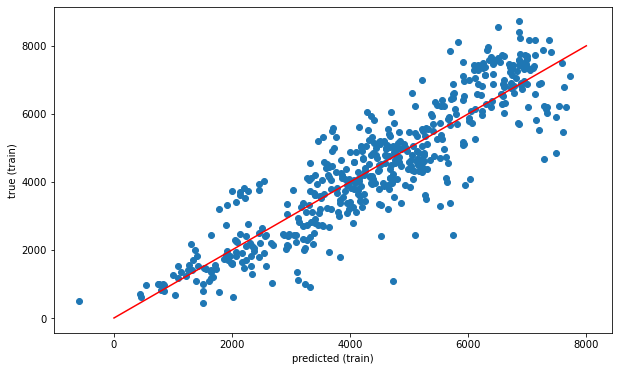

In [498]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(y_pred_train, y_train)
ax.set_xlabel('predicted (train)')
ax.set_ylabel('true (train)')
ax.plot(list(range(8000)), list(range(8000)), color = 'r')
plt.show()

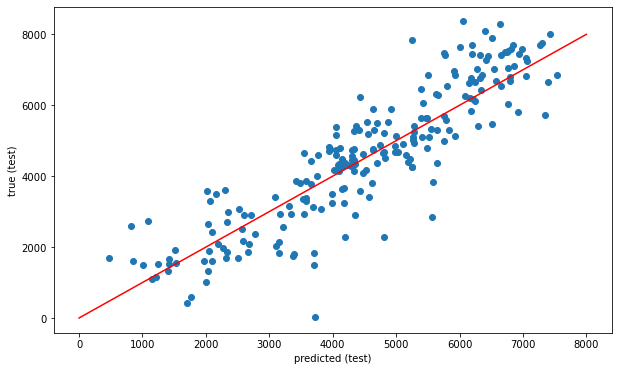

In [499]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(y_pred_test, y_test)
ax.set_xlabel('predicted (test)')
ax.set_ylabel('true (test)')
ax.plot(list(range(8000)), list(range(8000)), color = 'r')
plt.show()

- Essentially the same accuracy as when we used 15 features

<h3> Check distribution of residuals </h3>

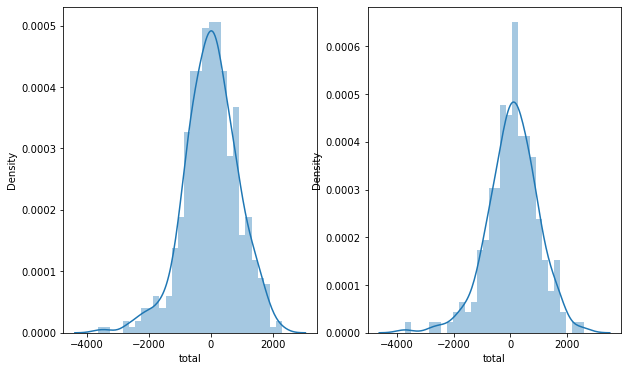

In [500]:
res_train = y_train - y_pred_train
res_test = y_test - y_pred_test
fig, ax = plt.subplots(1,2,figsize = (10,6))
sns.distplot(ax = ax[0], a = res_train, bins = 30)
sns.distplot(ax = ax[1], a = res_test, bins = 30)
plt.show()

- Excellent. Distribution of residuals is Gaussian.

<h5> Use plot_regress_exog function from statsmodels module (mostly to see plot of residuals) </h5> 

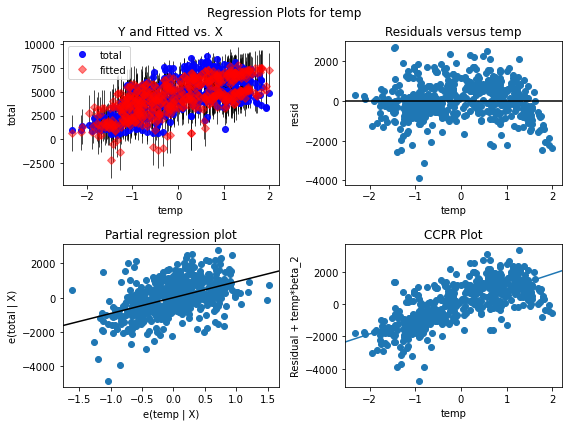

In [501]:
results = sm.OLS(endog = y_train, exog = X_train).fit()
fig = plt.figure(figsize=(8, 6))
sm.graphics.plot_regress_exog(results, 'temp', fig=fig) #Check as function of "temp" variable
plt.show()

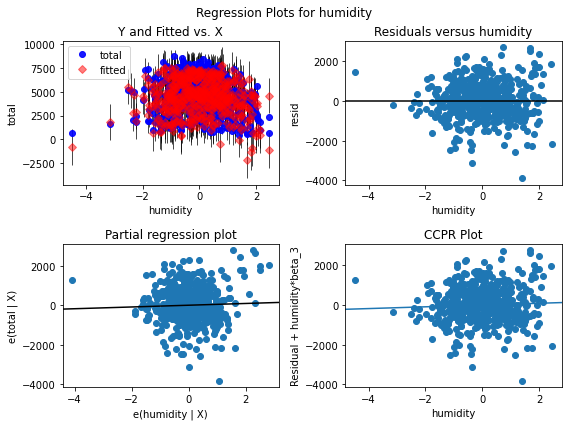

In [502]:
results = sm.OLS(endog = y_train, exog = X_train).fit()
fig = plt.figure(figsize=(8, 6))
sm.graphics.plot_regress_exog(results, 'humidity', fig=fig) # Check as function of "humidity" variable
plt.show()

- Residuals seem randomly distributed as function of "temp" and "humidity."

<h5> Check coefficients </h5>

In [503]:
# Coefficients
dict(zip(basic_model.feature_names_in_, basic_model.coef_)), basic_model.intercept_

({'year_2012': 1972.629834307517,
  'wind_speed': -187.23257983820648,
  'temp': 1038.991084959344,
  'humidity': -148.79711700412025,
  'season_spring': -609.6506696404874,
  'season_summer': -982.8978659970954,
  'season_winter': -1269.6220733513615,
  'work_day_yes': 267.60037128927104,
  'weather_sit_clear': 1800.9559094260428,
  'weather_sit_misty': 1274.8024410321568},
 2426.682030055246)

- temperature has big positive correlation, which makes sense. Range of temperature is something like (-10,35), and within that range, higher is def. better
- humidity has negative correlation, which also makes sense. 
- spring and summer have big negative correlation, but this is because "weather_sit_clear" and "weather_sit_misty" have even bigger positive coefficients, and contain information about the season. So the coefficient of the seasons need to be negative to compensate. 
- work day has positive correlation, which makes sense. Majority of riders are registered users, who use bikes to commute.

<h3> In the next notebook (part 4), we'll use the features selected in this notebook and perform hyperparameter tuning  </h3>